In [5]:
import numpy as np
import torch
from torchvision import transforms, datasets
import networkx as nx
import dgl
from dgl.dataloading import GraphDataLoader
import pandas as pd
from dgl.data import DGLDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from dgl.nn import GraphConv
import torch.nn.functional as F

Using backend: pytorch


Should not use GCN for MNIST. This is just a sample of using GCN

In [2]:
!pip install networkx

  Using cached networkx-2.8.4-py3-none-any.whl (2.0 MB)


In [4]:
!pip install dgl

  Using cached dgl-0.6.1-cp39-cp39-win_amd64.whl (3.1 MB)
  Using cached scipy-1.8.1-cp39-cp39-win_amd64.whl (36.9 MB)


In [6]:
#Load MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081, ))
    ])

train_set = datasets.MNIST('data/MNIST', train=True, download=True,
                           transform=transform)
test_set = datasets.MNIST('data/MNIST', train=False, download=True,
                          transform=transform)

In [7]:
#Convert to graph
class SyntheticDataset(DGLDataset):
    def __init__(self, dataset):
        self.dataset = dataset
        super().__init__(name='synthetic')

    def process(self):
        self.graphs = []
        self.labels = []

        B, H, W = self.dataset.train_data.shape
        pixel_ids = torch.arange(H, dtype=torch.long).repeat((H, 1))
        offset = torch.arange(H, dtype=torch.long).reshape(-1, 1) * W
        pixel_ids += offset
        row_edges = torch.cat([pixel_ids[:, i:i + 2] for i in range(W - 1)], dim=0) # edges connecting pixels in the same row
        col_edges = torch.cat([pixel_ids[i: i + 2, :].t() for i in range(H - 1)], dim=0)
        graph_edges = torch.cat([row_edges, col_edges], dim=0)
        # use double edges, because if A is connected to B then B is connected to A
        graph_edges = torch.cat([graph_edges, graph_edges[:, [-1, -2]]], dim=0)
        senders, receivers = graph_edges.unbind(dim=-1)
        num_nodes = W*H

        for i in range(len(self.dataset)):
            
            label = self.dataset.train_labels[i]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((senders, receivers), num_nodes=num_nodes)
            g.ndata['attr'] = self.dataset.train_data[i].reshape(-1,1)
            self.graphs.append(g)
            self.labels.append(label)
        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [8]:
train_dataset = SyntheticDataset(train_set)
test_dataset = SyntheticDataset(test_set)

C:\Users\Admin\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Admin\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


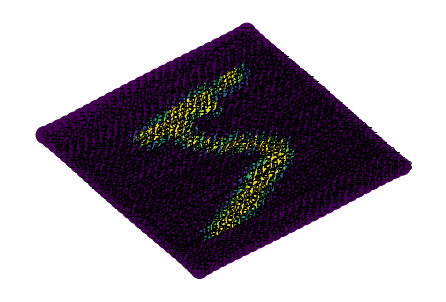

In [10]:
#Draw first graph
graph, label = train_dataset[0]
pos = nx.kamada_kawai_layout(graph.to_networkx().to_undirected())
nx.draw(graph.to_networkx().to_undirected(), pos, with_labels=True, node_color=graph.ndata['attr'])
plt.show()

In [11]:
#Make loader
train_dataloader = GraphDataLoader(train_dataset, batch_size=64, drop_last=False)
test_dataloader = GraphDataLoader(test_dataset, batch_size=64, drop_last=False)

In [14]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(1, 16)
        self.conv2 = GraphConv(16, 64)
        self.conv3 = GraphConv(64, 128)
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(64)
        self.map_to_class = nn.Sequential(nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Linear(128, 10))

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = self.bn1(h)
        h = F.relu(h) 
        h = self.conv2(g, h)
        h = self.bn2(h)
        h = F.relu(h) 
        h = self.conv3(g, h)
        g.ndata['h'] = h
        x = dgl.mean_nodes(g, 'h')
        return self.map_to_class(x)

# Create the model with given dimensions
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

target_epochs = 10
for epoch in range(target_epochs):
    num_correct = 0
    epoch_loss = 0
    for num_iter, (batched_graph, labels) in enumerate(train_dataloader):
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        epoch_loss += loss.item()

    train_loss.append(epoch_loss / (num_iter + 1))
    train_acc.append(num_correct / len(train_set))

    num_correct = 0
    epoch_loss = 0
    for num_iter, (batched_graph, labels) in enumerate(test_dataloader):
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        epoch_loss += loss.item()

    test_loss.append(epoch_loss / (num_iter + 1))
    test_acc.append(num_correct / len(test_set))
    print(f"epoch: {epoch + 1}/{target_epochs} - loss: {train_loss[-1]:.4f} - accuracy: {train_acc[-1]:.4f}"
                f" - test_loss: {test_loss[-1]:.4f} - test_acc: {test_acc[-1]:.4f}")

epoch: 1/10 - loss: 1.4992 - accuracy: 0.4454 - test_loss: 0.9981 - test_acc: 0.5083
epoch: 2/10 - loss: 1.3635 - accuracy: 0.4984 - test_loss: 0.9568 - test_acc: 0.5167
epoch: 3/10 - loss: 1.3354 - accuracy: 0.5089 - test_loss: 0.9494 - test_acc: 0.5270
epoch: 4/10 - loss: 1.3143 - accuracy: 0.5177 - test_loss: 0.9343 - test_acc: 0.5351
epoch: 5/10 - loss: 1.3585 - accuracy: 0.5056 - test_loss: 0.9680 - test_acc: 0.5401
epoch: 6/10 - loss: 1.2809 - accuracy: 0.5321 - test_loss: 0.9458 - test_acc: 0.5452
epoch: 7/10 - loss: 1.2627 - accuracy: 0.5369 - test_loss: 0.9032 - test_acc: 0.5488
epoch: 8/10 - loss: 1.4143 - accuracy: 0.4885 - test_loss: 1.0966 - test_acc: 0.5074
epoch: 9/10 - loss: 1.3301 - accuracy: 0.5102 - test_loss: 1.0691 - test_acc: 0.5183
epoch: 10/10 - loss: 1.4426 - accuracy: 0.4741 - test_loss: 1.0051 - test_acc: 0.5099
